In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import json
import h5py
import numpy as np
from zipfile import ZipFile
import imageio

In [3]:
def get_local(ur_image, parameter):

    im = ur_image

    # Get the original image from the in painting zone
    eye_left_center_x = parameter['eye_left']['x']
    eye_left_center_y = parameter['eye_left']['y']
    eye_left_width = parameter['eye_left']['box_left']['w']
    eye_left_height = parameter['eye_left']['box_left']['h']

    eye_right_center_x = parameter['eye_right']['x']
    eye_right_center_y = parameter['eye_right']['y']
    eye_right_width = parameter['eye_right']['box_right']['w']
    eye_right_height = parameter['eye_right']['box_right']['h']

    # Get the completion zones from ur_image
    el_y1 = max(0, int(eye_left_center_y - eye_left_height / 2))  # up
    el_y2 = min(80, int(eye_left_center_y + eye_left_height / 2))  # down
    el_x1 = int(eye_left_center_x - eye_left_width / 2)  # left
    el_x2 = int(eye_left_center_x + eye_left_width / 2)  # right

    er_y1 = max(0, int(eye_right_center_y - eye_right_height / 2))
    er_y2 = min(80, int(eye_right_center_y + eye_right_height / 2))
    er_x1 = int(eye_right_center_x - eye_right_width / 2)
    er_x2 = int(eye_right_center_x + eye_right_width / 2)

    left_patch = im[el_y1:el_y2, el_x1:el_x2, ...]
    right_patch = im[er_y1:er_y2, er_x1:er_x2, ...]

    # Resize each into shape (100 * 100 *3)
    lp = cv2.resize(left_patch, (100, 100), interpolation=cv2.INTER_LINEAR)
    rp = cv2.resize(right_patch, (100, 100), interpolation=cv2.INTER_LINEAR)
    completion = cv2.hconcat([lp, rp])

    # Return a concatenated image of the left and right completion zone image
    return completion

In [4]:
zip_path = '/content/drive/My Drive/Colab Notebooks/Data/celeb_id_cropped.zip'

with ZipFile(zip_path, 'r') as zf:
    raw_file_list = zf.namelist()
    file_list = [file for file in raw_file_list if file.startswith('celeb_id_cropped/')]
    file_list = file_list[1:]
    print(file_list[1678])

celeb_id_cropped/jasmine-washington-4.jpg


In [5]:
def check(param):
    if param[0] - param[2] / 2 <= 0:
        return 1
    if param[4] + param[6] / 2 >= 256:
        return 1

In [6]:
%%time

zip_path = '/content/drive/My Drive/Colab Notebooks/Data/celeb_id_cropped.zip'
json_dir = '/content/drive/My Drive/Colab Notebooks/Data/parameters.json'
train_dir = '/content/drive/My Drive/Colab Notebooks/Data/train.h5py'

train_image = 80000

with open(json_dir, 'r') as f:
    parameters = json.load(f)

with ZipFile(zip_path, 'r') as zf:
    raw_file_list = zf.namelist()
    file_list = [file for file in raw_file_list if file.startswith('celeb_id_cropped/')]
    file_list = file_list[1:]

    count = 0

    with h5py.File(train_dir, 'w') as hdf:
        hdf.create_dataset('in_image', shape=(train_image, 80, 256, 3), dtype=np.uint8)
        hdf.create_dataset('local', shape=(train_image, 100, 200, 3), dtype=np.uint8)
        hdf.create_dataset('parameters', shape=(train_image, 8), dtype='i')

        for file in file_list:
            if count == train_image:
                break

            if not (file.lower().endswith('.jpg')):
                continue

            ofile = zf.extract(file)
            img = imageio.imread(ofile)

            parameter = parameters[str(os.path.basename(file))]
            param = []
            param.append(parameter['eye_left']['x'])
            param.append(parameter['eye_left']['y'])
            param.append(parameter['eye_left']['box_left']['w'])
            param.append(parameter['eye_left']['box_left']['h'])
            param.append(parameter['eye_right']['x'])
            param.append(parameter['eye_right']['y'])
            param.append(parameter['eye_right']['box_right']['w'])
            param.append(parameter['eye_right']['box_right']['h'])

            flag = check(param)
            if flag:
                os.remove(ofile)
                continue

            hdf['parameters'][count] = param

            in_image = img[0:80, 0:256, ...]
            ur_image = img[80:160, 0:256, ...]
            hdf['in_image'][count] = in_image

            local = get_local(ur_image, parameter)
            hdf['local'][count] = local

            os.remove(ofile)

            count += 1
            if count % 1000 == 0:
                print("Images Processed:", count)
                pass

print("Total Count:", count)

<timed exec>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Images Processed: 1000
Images Processed: 2000
Images Processed: 3000
Images Processed: 4000
Images Processed: 5000
Images Processed: 6000
Images Processed: 7000
Images Processed: 8000
Images Processed: 9000
Images Processed: 10000
Images Processed: 11000
Images Processed: 12000
Images Processed: 13000
Images Processed: 14000
Images Processed: 15000
Images Processed: 16000
Images Processed: 17000
Images Processed: 18000
Images Processed: 19000
Images Processed: 20000
Images Processed: 21000
Images Processed: 22000
Images Processed: 23000
Images Processed: 24000
Images Processed: 25000
Images Processed: 26000
Images Processed: 27000
Images Processed: 28000
Images Processed: 29000
Images Processed: 30000
Images Processed: 31000
Images Processed: 32000
Images Processed: 33000
Images Processed: 34000
Images Processed: 35000
Images Processed: 36000
Images Processed: 37000
Images Processed: 38000
Images Processed: 39000
Images Processed: 40000
Images Processed: 41000
Images Processed: 42000
I

[ 69  42  48  48 185  39  48  48]


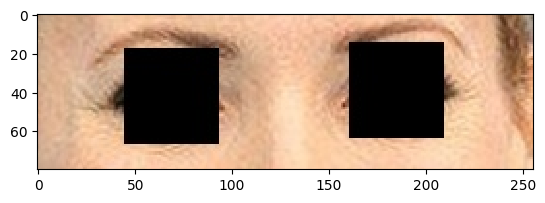

In [8]:
import matplotlib.pyplot as plt

train_dir = '/content/drive/My Drive/Colab Notebooks/Data/train.h5py'

with h5py.File(train_dir, 'r') as hdf:
    index = 70000
    masked = hdf['in_image'][index]
    local = hdf['local'][index]
    parameter = hdf['parameters'][index]
    print(parameter)
    plt.imshow(masked, interpolation='none')
    # plt.imshow(local, interpolation='none')
    pass